In [1]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import os
import torch
import helper
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm.notebook import tqdm
import torch.optim as optim

from PIL import Image 
from google.colab import drive
drive.mount('/content/drive')

data_path = './drive/MyDrive/Datasets'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Utility 
class LinearFilter:
    def __init__(self, kernel):
        """
        kernel: torch.nn.Conv2D kernel
        """
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        with torch.no_grad():
            return kernel(x)

class Left_Operator_ADMM:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, LinearFilter, Adjoint_LinearFilter, sigma_2, eta):
        self.linear_filter = LinearFilter
        self.adj_linear_filter = Adjoint_LinearFilter
        self.sigma_2_over_eta = sigma_2/eta
    
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        p = self.sigma_2_over_eta*x
        q = self.adj_linear_filter(self.linear_filter(x))
        return (p+q)

class Right_Operator_ADMM:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, Adjoint_LinearFilter, sigma_2, eta, y):
        self.sigma_2_over_eta = sigma_2/eta
        self.Ahy =  Adjoint_LinearFilter(y)
    
    def __call__(self, z):
        return self.forward(z)

    def forward(self, z):
        return  self.Ahy + self.sigma_2_over_eta*z

class Denoiser:
    """
    Refer to paper "PNP methods for MRI" p. 108 eq.(12)
    """
    def __init__(self, DNN_Denoiser):
        self.dnn_denoiser = DNN_Denoiser.eval()
    
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        with torch.no_grad():
            return self.dnn_denoiser(x)

def loss(x, y):
    l1 = nn.L1Loss()
    # l2 = nn.MSELoss()
    return (l1(x,y)*(1-ms_ssim(x,y,data_range=1.0, size_average=True, win_size=3, win_sigma=0.5)))
    # return (l1(x,y)*(1-ssim(x,y,data_range=1.0, size_average=True)))

def train(model, optimizer, sample):
    model.train()
    # criterion = nn.MSELoss() 
    criterion = loss
    optimizer.zero_grad()

    input = sample['input'].to(device)
    target = sample['target'].to(device) 
    
    pred = model(input)
    pred_loss = criterion(pred, target)
    
    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item()

def validate(model, sample):
    model.eval()

    criterion = nn.MSELoss()

    with torch.no_grad():
        input = sample['input'].to(device)
        target = sample['target'].to(device) 

        pred = model(input)
        pred_loss = criterion(pred, target)


    return pred_loss.item()

# Conjugate gradient method
def cg(A, b, x0, numit, tol):
    x = x0
    r = b-A(x)
    d = r
    for _ in range(numit):
        z = A(d)
        rr = torch.sum(r**2)
        alpha = rr/torch.sum(d*z)
        x += alpha*d
        r -= alpha*z
        if torch.norm(r) < tol:
            break
        beta = torch.sum(r**2)/rr
        d = r + beta*d        
    return x

# ADMM
def PnP_ADMM(Left_Operator, Right_Operator, Denoiser, x0, numit, num_cgit = 4, cg_tol = 1e-6):
    x = x0;
    u = torch.zeros_like(x)
    v = Denoiser(x+u)
    for _ in range(numit):
        b = Right_Operator(v-u)
        x = cg(Left_Operator, b, x, num_cgit, cg_tol)
        v = Denoiser(x+u)
        u += (x - v)
    
    return (x,v,u)

# PSNR
def compute_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return "Same Image"
    return (10 * torch.log10(torch.max(img1) / mse)).item()


# Test denoising performance

def denoising_performance(test_image):
  
  noise = 0.05
  image_path = data_path + '/' + test_image + '.png'
  img = Image.open(image_path)
  img = torchvision.transforms.ToTensor()(img)
  target = img.unsqueeze(0).to(device).to(dtype)
  input = img.unsqueeze(0).to(device).to(dtype)

  input = input + noise*torch.randn_like(input)

  model.eval()
  with torch.no_grad():
      model_out = model(input)
      # model_out = input - model_out

  # Plot
  fig, ax = plt.subplots(1, 3, figsize=(15, 5))
  ax[0].imshow(input[0].detach().cpu().squeeze().permute(1,2,0),)
  ax[1].imshow(model_out[0].detach().cpu().squeeze().permute(1,2,0),)
  ax[2].imshow(target[0].detach().cpu().squeeze().permute(1,2,0),)
  for axs in ax:
      axs.set_xticks([])
      axs.set_yticks([])

  if 'lena' in image_path or 'monarch' in image_path or 'parrot' in image_path:
    if 'lena' in image_path:
      input_plot = input[0][:, 250:300, 240:290]
      model_plot = model_out[0][:, 250:300, 240:290]
      gt_plot = target[0][:, 250:300, 240:290]
    elif 'monarch' in image_path:
      input_plot = input[0][:, 200:250, 325:375]
      model_plot = model_out[0][:, 200:250, 325:375]
      gt_plot = target[0][:, 200:250, 325:375]
    elif 'parrot' in image_path:
      input_plot = input[0][:, 200:250, 190:240]
      model_plot = model_out[0][:, 200:250, 190:240]
      gt_plot = target[0][:, 200:250, 190:240]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].imshow(input_plot.detach().cpu().squeeze().permute(1,2,0),)
    ax[1].imshow(model_plot.detach().cpu().squeeze().permute(1,2,0),)

    for axs in ax:
        axs.set_xticks([])
        axs.set_yticks([])

    print(round(compute_psnr(gt_plot, model_plot),2))
  else:
    print(round(compute_psnr(input, model_out),2))


# PnP algorithm

def pnp(test_image):

  image_path = data_path + '/' + test_image + '.png'
  img = Image.open(image_path)
  img = torchvision.transforms.ToTensor()(img)
  gt = img.unsqueeze(0).to(device).to(dtype)
  # Downsampling
  pr = 0.2 # Sampling probability
  P = torch.empty(gt.shape[2], gt.shape[3]).uniform_(pr, pr)
  P = torch.bernoulli(P).to(device).to(torch.bool) # Mask

  # Linear operator
  F =  torchvision.transforms.GaussianBlur(2*3*1.6,(1.6,1.6))
  def A(x): # Operator A (as in y = Ax + noise)
      y = torch.zeros_like(x)
      y[:,:,P] = F(x)[:,:,P]
      return y
  def Ah(y): # Adjoint operator A (as in y = Ax + noise)
      x = torch.zeros_like(y)
      x[:,:,P] = y[:,:,P]
      return F(x)

  # noise level (image range [0, 1])
  noise = 0.01
  print('white noise std: ', noise)
  # get measurements y = Ax + noise
  y = A(gt)+noise*torch.randn_like(gt).to(device)

  #@title ADMM
  # Hyperparameter
  eta = 1
  sigma_2 = 0.1*eta
  left_operator = Left_Operator_ADMM(A, Ah, sigma_2, eta)
  right_operator = Right_Operator_ADMM(Ah, sigma_2, eta, y)

  # Plug in Denoiser
  denoiser = Denoiser(model.to(dtype))

  # Play algorithm
  x0 = Ah(y) # init
  sol = PnP_ADMM(left_operator, right_operator, denoiser, x0, numit=100, num_cgit=4, cg_tol=1e-6)
  xpnp = sol[1]

  # PSNR
  print('PSNR: ', compute_psnr(gt, xpnp))
  print('SSIM: ', ssim(gt,xpnp,data_range=1.0).item())
  # Plot
  fig, ax = plt.subplots(1, 3, figsize=(20, 10))
  ax[0].imshow(y.detach().cpu().squeeze().permute(1,2,0),)
  ax[1].imshow(xpnp.detach().cpu().squeeze().permute(1,2,0),)
  ax[2].imshow(gt.detach().cpu().squeeze().permute(1,2,0),)
  for axs in ax:
      axs.set_xticks([])
      axs.set_yticks([])

In [3]:
#@title Dataset class
class Dataset(Dataset):
    def __init__(self, data_path, is_training):
        self.data_path = data_path
        self.train_path = os.path.join(data_path, 'train')
        self.val_path = os.path.join(data_path, 'val')
        self.is_training = is_training
        if self.is_training:
            self.target_path = self.train_path
        else:
            self.target_path = self.val_path

        self.img_list = sorted(os.listdir(self.target_path))
        self.img_path_label = list()
        for fp in self.img_list:
            full_fp = os.path.join(self.target_path, fp)
            self.img_path_label.append(full_fp)


        self.img_size = 512
        self.patch_size = 40
        # Add some tranforms for data augmentation.
        self.tensor_transform = torchvision.transforms.ToTensor()
        self.random_crop = torchvision.transforms.RandomCrop(size = self.patch_size, pad_if_needed=False)
        self.resize = torchvision.transforms.Resize(size=(self.img_size, self.img_size))
        self.rgb2gray = torchvision.transforms.Grayscale(num_output_channels=1)
        self.gaussianblur = torchvision.transforms.GaussianBlur(5, (1,1))

        if self.is_training:

            self.transform = torchvision.transforms.Compose([
                                                             self.tensor_transform,
                                                            # self.rgb2gray,
                                                            # self.resize,
                                                            self.random_crop,
                                                            # self.gaussianblur
                                                            ])
        else:
            self.transform = torchvision.transforms.Compose([
                                                             self.tensor_transform,
                                                            ])

    def __len__(self):
        # return len(self.img_path_label)
        return 3000

    def __getitem__(self, idx):
        idx = torch.randint(0, len(self.img_path_label), (1,))
        fp = self.img_path_label[idx]
        img = Image.open(fp)

        if self.is_training:
            input = self.tensor_transform(img)
            input = self.random_crop(input)
        else:
            input = self.tensor_transform(img)
            
        # noise = 0.2*torch.std(input)
        noise = 0.05
        sample = dict()
        sample['input'] = input + noise*torch.randn_like(input)
        sample['target'] = input
        return sample

In [4]:
#@title Create dataset
batch_size = 32
train_dataset = Dataset(data_path, True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = Dataset(data_path, False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


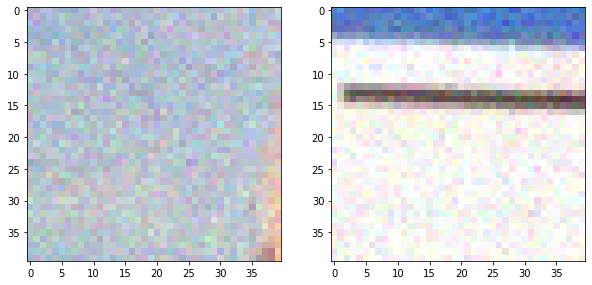

In [5]:
#@title Sample from dataloader
sample = next(iter(train_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ax[i].imshow(sample['input'][i].permute(1,2,0))

In [6]:
#@title Device and data type
device = 'cuda'
dtype = torch.float32

In [7]:
#@title Network Model class

class Model(nn.Module):
    def __init__(self, dim):
        super(Model, self).__init__()

        self.num_feature_maps = 64
        self.filter_size = 3

        self.in_conv2d = nn.Conv2d(dim, self.num_feature_maps, self.filter_size, padding = 1)

        self.hid1 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)
        self.hid2 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid3 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 4, padding = 4)
        self.hid4 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 3, padding = 3)
        self.hid5 = nn.Conv2d(self.num_feature_maps, self.num_feature_maps, self.filter_size, dilation = 2, padding = 2)

        self.out_conv2d = nn.Conv2d(self.num_feature_maps, dim, self.filter_size, padding = 1)
        
        self.bn2d = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(p=0.0)
        self.h = nn.ReLU()
        
    def forward(self, img):

        out = self.dropout(self.h(self.in_conv2d(img)))
        out = self.dropout(self.h((self.hid1(out))))
        out = self.dropout(self.h((self.hid2(out))))
        out = self.dropout(self.h((self.hid3(out))))
        out = self.dropout(self.h((self.hid4(out))))
        out = self.dropout(self.h((self.hid5(out))))

        out = img-self.out_conv2d(out)

        return out

In [8]:
#@title Create or load NN model

model = Model(dim=3).to(device)
print('model output shape:', model(sample['input'].to(device)).shape)

# # Or load exisiting model
# checkpoint = torch.load('./drive/MyDrive/Plug and Play/Denoiser Models/denoiser_rgb_3.pth')
# model = checkpoint['model']
# model.load_state_dict(checkpoint['model_state_dict'])
# model = model.to(device)

model output shape: torch.Size([32, 3, 40, 40])


In [9]:
#@title Network training
max_epoch = 8
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    # Initialize Loss
    train_loss = 0.0

    # Iterate over the train_dataloader
    with tqdm(total=len(train_dataloader)) as pbar:
        for idx, sample in enumerate(train_dataloader):
            curr_loss = train(model, optimizer, sample)
            train_loss += curr_loss / len(train_dataloader)
            pbar.update(1)
    #scheduler.step()

    # ### Validation Phase
    # # Initialize Loss and Accuracy
    val_loss = 0.0

    print('Epoch {}, Train loss.: {}'.format(epoch, train_loss, val_loss))


Epoch 0, Train loss.: 0.003641747631766694



Epoch 1, Train loss.: 0.0032625291793745882



Epoch 2, Train loss.: 0.0015717397878649941



Epoch 3, Train loss.: 0.0007283546790936366



Epoch 4, Train loss.: 0.0005495941004483031



Epoch 5, Train loss.: 0.0005108220236465095



Epoch 6, Train loss.: 0.0004490012447894649



Epoch 7, Train loss.: 0.00042965859168536094



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30.89


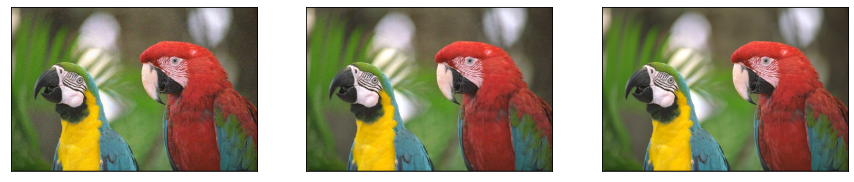

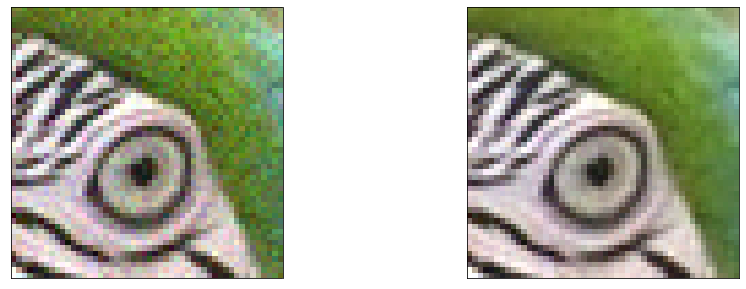

In [13]:
# Test denoising performance on test images: 'lena', 'monarch' or 'parrot'
denoising_performance('parrot')

white noise std:  0.01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR:  29.30364227294922
SSIM:  0.7755717635154724


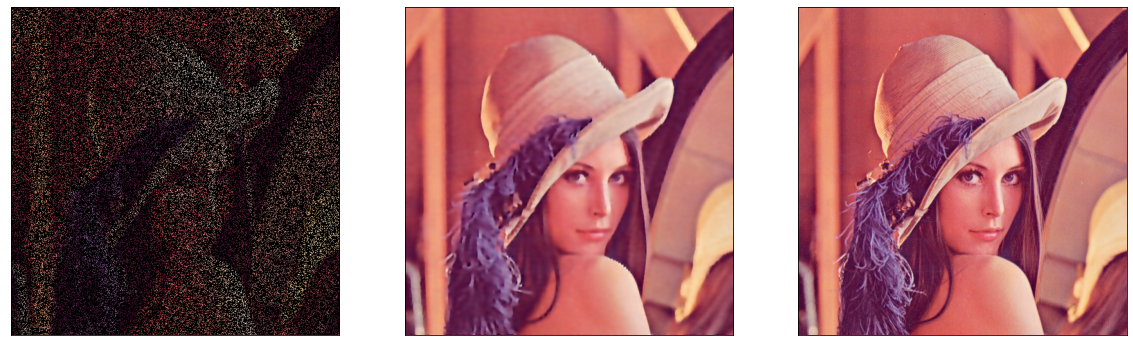

In [14]:
# Test the PnP denoiser performance on test images: 'lena', 'monarch' or 'parrot'
pnp('lena')

In [12]:
#@title Save model
# Save model
checkpoint = {
    'model' : Model(3),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}
torch.save(checkpoint, './drive/MyDrive/Plug and Play/denoiser.pth')